# League of Legends win rates by tier

An exploration of champion win rates by tier. Hypothesis: certain high skill champions like Nidalee win more when played by Platinum players compared to Silver players. Conversely certain cheese champions like Amumu win more in Silver players, where they are mostly against lower skill players.

Data comes from http://na.op.gg/statistics/champion/ and represents approximately 15 million games played in the month ending September 12 2016.

By Nelson Minar <nelson@monkey.org>

In [1]:
import pandas, collections, numpy, seaborn
from IPython.core.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns;
sns.set_palette('deep')

In [2]:
tier_names = ['Bronze', 'Silver', 'Gold', 'Platinum', 'Diamond', 'Master', 'Challenger']

right_align = [{'selector': 'td', 'props': [('text-align', 'right')]}]  # for DataFrame.style

## Load and prepare the data

In [3]:
# Create a bunch of DataFrames, one per CSV file
tiers = {}
for tier in tier_names:
    tiers[tier] = pandas.read_csv('data/Champion win rates by tier - %s.tsv' % tier,
                                  sep='\t', header=0,
                                  names=['N', 'X', 'champion', 'winrate', 'games', 'kda', 'cs', 'gold'],
                                  thousands = ',',
                                  index_col = 2)
    # Remove unneeded columns
    del tiers[tier]['X']
    del tiers[tier]['N']
    # Parse a couple of columns down to simple numbers
    tiers[tier]['winrate'] = tiers[tier]['winrate'].apply(lambda s: float(s[:-1]))
    tiers[tier]['kda'] = tiers[tier]['kda'].apply(lambda s: float(s[:-2]))

# Smoosh all the DataFrames into a single Panel
data = pandas.Panel(tiers, items = tier_names)

## Sample data for Nidalee

In [4]:
data.xs('Nidalee')

Bronze    Silver      Gold  Platinum   Diamond    Master  \
winrate     41.45     44.59     48.14     51.00     53.96     61.45   
games    17466.00  58051.00  52953.00  39436.00  12505.00    664.00   
kda          2.04      2.38      2.70      2.92      3.13      3.59   
cs         107.19    122.93    133.71    138.80    142.22    144.76   
gold     11625.00  12232.00  12708.00  12806.00  12767.00  12992.00   

         Challenger  
winrate       57.21  
games        208.00  
kda            3.97  
cs           146.22  
gold       12950.00

## Average statistics by tier

In [5]:
d = []
for t, df in data.iteritems():
    d.append((df['winrate'].mean(), 
              df['games'].mean(), 
              df['kda'].mean(), 
              df['cs'].mean(), 
              df['gold'].mean()))

averages = pandas.DataFrame(d, index = data.items, columns=('winrate', 'games', 'kda', 'cs', 'gold'))
(averages.style
    .format({'cs': "{:.0f}", 'games': '{:,.0f}', 'gold': '{:,.0f}', 'kda': '{:.2f}', 'winrate': "{:.2f}%"})
    .set_table_styles(right_align))

## Win rates by tier, alternate calculation

It seems odd that the total win rate across all data is < 50%. Perhaps they are including games that didn't complete?

In [6]:
d = []
for t, df in data.iteritems():
    winsPerChamp = df.games * df.winrate / 100
    d.append((100 * winsPerChamp.sum() / df.games.sum(), winsPerChamp.sum(), df.games.sum()))
tier_stats = pandas.DataFrame(d, index=data.items, columns=('win rate for tier', 'wins in tier', 'games in tier'))
(tier_stats.style
    .format({'games in tier': '{:,.0f}', 'win rate for tier': '{:.2f}%', 'wins in tier': '{:,.0f}'})
    .set_table_styles(right_align)
)

## Champion win rates from Silver to Diamond

Which champions do the most better in the hands of skilled players? Which champions' win rates fall off in higher tiers?

It turns out Nidalee has the most improvement for player skill; she goes from 44.59% win rate for Silver players to 53.96% in Diamond, a gain of 9.37%. Conversely Amumu loses 4.10% win rate.

The column "Silver to Diamond" is simply the difference in win rates in the two tiers. "Max Spread" is the difference between maximum and minimum win rate. It's uesful for champs like Blitzcrank that are strongest in Gold (+2.09%), not Platinum (+0.87%).

In [7]:
spreads = {}
for name in data.major_axis:
    champ_data = data.major_xs(name)
    # Consider only Silver -> Diamond data
    reduced = champ_data.transpose()[1:-2]
    spreads[name] = (
        reduced.winrate[-1] - reduced.winrate[0], 
        max(reduced.winrate) - min(reduced.winrate),
        data.Silver.loc[name].winrate,
        data.Gold.loc[name].winrate,
        data.Platinum.loc[name].winrate,
        data.Diamond.loc[name].winrate,
    )
win_rates = pandas.DataFrame.from_records(spreads, 
             index=('Silver to Diamond', 'Max Spread', 'Silver', 'Gold', 'Platinum', 'Diamond')).transpose()
win_rates.sort_values('Silver to Diamond', ascending=False, inplace=True)
df_disp = pandas.concat([win_rates.head(10), win_rates.tail(10)])
display(df_disp.style
     .format({'Silver to Diamond': '{:+.2f}%', 'Max Spread': '{:.2f}%',
              'Silver': '{:.2f}%', 'Gold': '{:.2f}%', 'Platinum': '{:.2f}%', 'Diamond': '{:.2f}%'})
     .set_table_styles(right_align)
     .background_gradient(cmap='coolwarm', low = 0.5, high= 0.5,
                          subset=['Silver', 'Gold', 'Platinum', 'Diamond'])
)


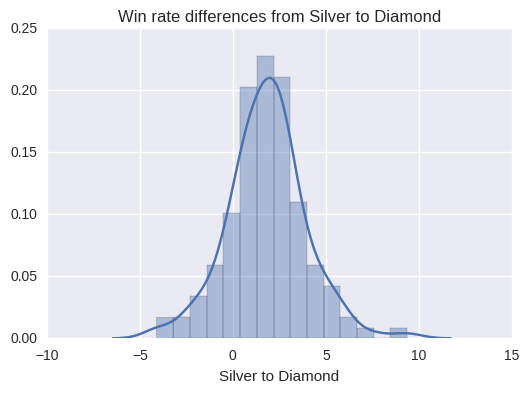

In [8]:
g = sns.distplot(win_rates['Silver to Diamond'], bins=15)
g.set(title='Win rate differences from Silver to Diamond')

## Champion popularity by tier

How popular are champions at various tiers? Which champions get more popular at higher tiers?

It turns out Janna has the most increase in usage in higher tiers. She's picked in only 0.79% of Silver examples (93,510 games out of 11.8M) but she's picked 2.92% of the time in Diamond examples (28,644 games out of 1M). Conversely Leona has the biggest drop in usage, from 1.63% to 0.63%.

Note that the raw numbers reported in Silver/Gold/Platinum/Diamond are not strictly pick rate, although they are mostly correlated. Janna represents 0.79% of all the Silver data we have. The report is sorted by the column "Silver to Diamond", the difference in pick rates from Silver to Diamond.

In [9]:
pick_rates = 100 * data.minor_xs('games') / data.minor_xs('games').sum()
del pick_rates['Bronze']
del pick_rates['Master']
del pick_rates['Challenger']
pick_rates.insert(0, 'Silver to Diamond', pick_rates.Diamond - pick_rates.Silver)
pick_rates.sort_values('Silver to Diamond', ascending=False, inplace=True)
df_disp = pandas.concat([pick_rates.head(10), pick_rates.tail(10)])
(df_disp.style
     .format({'Silver': '{:,.2f}', 'Gold': '{:,.2f}', 'Platinum': '{:,.2f}', 'Diamond': '{:,.2f}',
              'Silver to Diamond': '{:+.2f}'})
     .set_table_styles(right_align)
     .background_gradient(cmap='coolwarm', low = 0.5, high= 0.5,
                          subset=['Silver', 'Gold', 'Platinum', 'Diamond']))


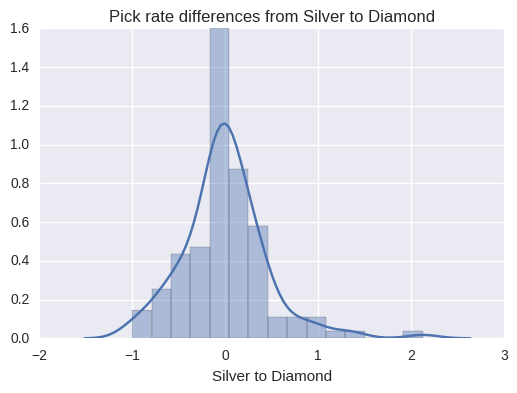

In [10]:
g = sns.distplot(pick_rates['Silver to Diamond'], bins=15)
g.set(title='Pick rate differences from Silver to Diamond')

## Scatterplot of Platinum win rate vs pick rate

Are high win rate champs more popular in platinum? Not particularly...

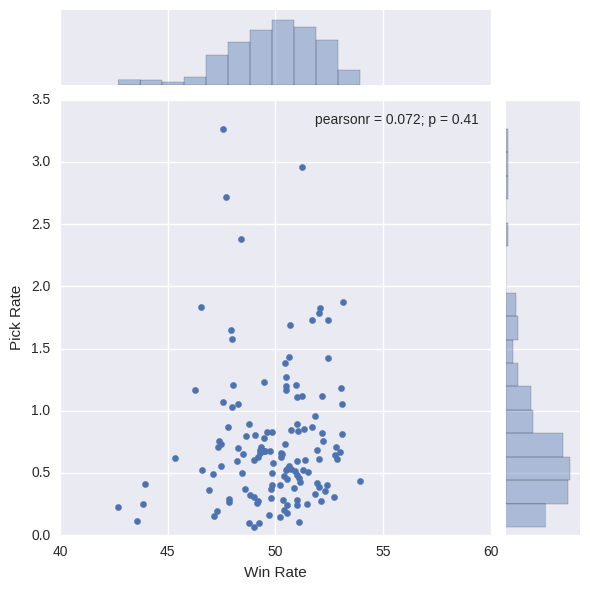

In [11]:
wr_vs_pick_platinum = pandas.concat((win_rates['Platinum'], pick_rates['Platinum']), axis=1)
wr_vs_pick_platinum.columns = ('Win Rate', 'Pick Rate')
g = sns.jointplot(x='Win Rate', y='Pick Rate', ylim=(0,3.5), xlim=(40,60), data=wr_vs_pick_platinum, kind="scatter")

## Scatterplot of Win Rate improvement vs Pick Rate change

Are champions that have a bigger Silver-to-Diamond win rate change also likely to have a higher pick rate Silver-to-Diamond? If there were a correlation you'd expect the dots below to fall on the line `x=y`. They don't really, but there is a correlation

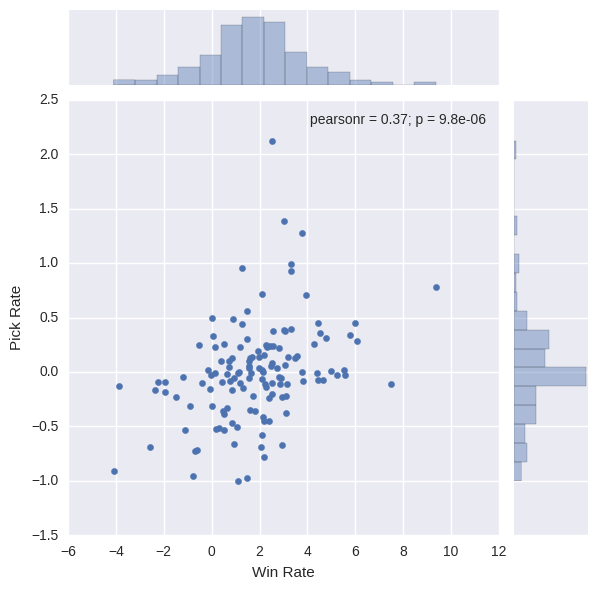

In [12]:
wr_vs_pick_sd = pandas.concat((win_rates['Silver to Diamond'], pick_rates['Silver to Diamond']), axis=1)
wr_vs_pick_sd.columns = ('Win Rate', 'Pick Rate')
g = sns.jointplot(x='Win Rate', y='Pick Rate', data=wr_vs_pick_sd, kind="scatter")